In [1]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            #!/usr/bin/env python
# coding: utf-8

In [1]:


import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from cucu_utils import *

debugFlag=False
if debugFlag:
    # DEBUG MODE:
    ROOT_DIR = os.path.abspath("/Users/AsherYartsev/Mask_RCNN")
else:
    # Root directory of the project
    ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# get_ipython().run_line_magic('matplotlib', 'inline')

#asher todo: change later to path inside cucu_train
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "cucu_train/weightsAndGraphs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
  





Using TensorFlow backend.


In [2]:




class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "cucumbers"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # IMAGES_PER_GPU = 2
    
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shape (cucumber)

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024
    
    # anchor side in pixels, for each of RPN layer
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  
       
    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32
    
    #asher todo: can we utilize it better?
    #ROI_POSITIVE_RATIO = 66  
    
    #asher todo: enlarge to 100 when real training occures
    STEPS_PER_EPOCH = 1

    VALIDATION_STEPS = 1
    
config = ShapesConfig()
config.display()



minimum_number_of_cucumbers = 10
maximum_number_of_cucumbers = 120
#number_of_cucumbers = 4
min_scale = 0.4
max_scale = 1.1


class CucuDataset(utils.Dataset):
    def __init__(self, folder_objects, folder_bgs):
        """
        self variables:
            folder_object - folder containing object asher todo: what is exactly an object? image +annotations?
            folder_bgs - todo: TBD
            img2 - container for all images in dataSet containing objects
            bg - container for all images in dataSet containing backGrounds
        """
        utils.Dataset.__init__(self)
        
        self.folder_objects = folder_objects
        self.folder_bgs = folder_bgs
        self.img2 = []
        self.bg = []
        for root, _, files in os.walk(self.folder_objects):
            for filename in files:
                #self.img2.append(cv2.cvtColor(cv2.imread(os.path.join(root, filename)), cv2.COLOR_BGR2RGB))
                self.img2.append(Image.open(os.path.join(root, filename)).convert('RGBA'))
        _, _, files_objects = next(os.walk(self.folder_objects))
        self.number_of_cucumbers = len(files_objects)
                
        for root, _, files in os.walk(self.folder_bgs):
            for filename in files:
                #self.bg.append(cv2.cvtColor(cv2.imread(os.path.join(root, filename)), cv2.COLOR_BGR2RGB))
                self.bg.append(Image.open(os.path.join(root, filename)).convert('RGBA'))
        _, _, files_bgs = next(os.walk(self.folder_bgs))
        self.number_of_bgs = len(files_bgs)
        print("folder: " + folder_objects + " inited")
        print("folder: " + folder_bgs + " inited")

    
    def load_shapes(self, count, height, width):
        """
        Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """

        # Add classes
        self.add_class("shapes", 1, "cucumber")
       
        # Add images
        for i in range(count):
            print('Image', i, end='\r')
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None, width=width, height=height, bg_color=bg_color, shapes=shapes)
            
    def load_image(self, image_id):
        """
        for now we only have one shape- cucumber.
        function creates 'collage' bg+one image.

        function is called by load_image_gt - it is crucial for generating on-the-fly training set 
        for NN.
        """
        info = self.image_info[image_id]
        
        index = random.randint(0, self.number_of_bgs-1) 
        
        y_max, x_max,channels = np.asarray(self.bg[index]).shape

        
        x = random.randint(0, x_max-1024)
        y = random.randint(0, y_max-1024)
        
        #image = self.bg[index][y:y+1024, x:x+1024,:]
        area = (x, y, x+1024, y+1024)
        image = self.bg[index].crop(area)
        
        for shape, location, scale, angle, index in info['shapes']:
            image = self.draw_shape(image, shape, location, scale, angle, index)
        npImage = np.array(image)
        # remove transparency channel to fit to network data
        ImageWithoutTransparency = npImage[:,:,:3]
        return ImageWithoutTransparency
    
    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    
    
    def createMaskedImageByIndex(self, mask, shape, location, scale, angle, index):
        """
        function takes an image from self.img2[index] and pastes it on a given mask
        """
        x_location, y_location = location
        x_scale, y_scale = scale
        
        fig, (ax1, ax2) = plt.subplots(1,2)

        
        img2 = self.img2[index]
        ax1.imshow(img2)

        img1 = mask
        img2 = cv2.resize(img2,None,fx=x_scale, fy=y_scale, interpolation = cv2.INTER_CUBIC)

        # I want to put logo on top-left corner, So I create a ROI
        rows,cols,channels = img2.shape

        #Rotate
        img2 = rotate_bound(img2, angle)

        #ax2.imshow(mask, cmap='gray')
        
        ax2.imshow(img2)

        
        roi = img1[y_location:rows+y_location, x_location:cols+x_location ]

        # Now create a mask of logo and create its inverse mask also
        img2gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
        ret, mask = cv2.threshold(img2gray, 1, 255, cv2.THRESH_BINARY)
        mask_inv = cv2.bitwise_not(mask)
        # Now black-out the area of logo in ROI
        img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
        # Take only region of logo from logo image.
        img2_fg = cv2.bitwise_and(img2,img2,mask = mask)
        # Put logo in ROI and modify the main image
        dst = cv2.add(img1_bg,img2_fg)
        # asher todo: the line of code below won't work: x_offset is not defined
        img1[y_location:rows+y_location, x_offset:cols+x_location ] = dst
        
        x_location, y_location = location
        x_scale, y_scale = scale
        mask = add_image(mask, self.img2[index], x_location, y_location, x_scale, y_scale, angle)
        return mask
    
    def draw_shape_without_transparency(self, image, shape, location, scale, angle, index):
        """Draws a shape from the given specs."""
        if shape == 'cucumber':
            x_location, y_location = location
            x_scale, y_scale = scale
            image = add_imageWithoutTransparency(image, np.array(self.img2[index]),                                                             x_location, y_location, x_scale, y_scale, angle)
        return image


    def draw_shape(self, Collage, shape, location, scale, angle, index):
        """
        Draws another cucumber on a selected background
        Get the center x, y and the size s
        x, y, s = dims
        """
        

        if shape == 'cucumber':
            #print("leaf added")
            #i=0
            x_location, y_location = location
            x_scale, y_scale = scale
            # print(type(self.img2[index]))
            Collage = add_image(Collage, self.img2[index], x_location, y_location, x_scale, y_scale, angle)
        # asher todo: else?
        return Collage
    
    
    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["cucumber"])
        # Color
        # TopLeft x, y
        x_location = random.randint(0, height)
        y_location = random.randint(0, width)
        # Scale x, y
        x_scale = random.uniform(min_scale, max_scale)
        y_scale = random.uniform(min_scale, max_scale)
        # Angle
        angle = random.randint(0, 359)
        # Image index
        index = random.randint(0, self.number_of_cucumbers-1)
        
        return shape, (x_location, y_location), (x_scale, y_scale), angle, index
    
    # asher note: we don't use this func. for now
    def random_image_opencv(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        indexes  = []
        N = random.randint(minimum_number_of_cucumbers, maximum_number_of_cucumbers)
        
        image = np.ones([height, width, 3], dtype=np.uint8)
        
        for _ in range(N):
            shape, location, scale, angle, index = self.random_shape(height, width)
            
            image = add_image(image, self.img2[index], location[0], location[1], scale[0], scale[1], angle)
            y, x, _ = self.img2[index].shape
            
            #shapes.append((shape, color, dims))
            shapes.append((shape, location, scale, angle, index))
            #TODO boxes
            #x, y, s = dims
            #boxes.append([y-s, x-s, y+s, x+s])
            boxes.append([location[1], location[0], location[1] + y, location[0] + x])
            
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes
    
    
    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        indexes  = []
        N = random.randint(minimum_number_of_cucumbers, maximum_number_of_cucumbers)
            
        for _ in range(N):
            shape, location, scale, angle, index = self.random_shape(height, width)
            # asher todo: do we need this?
            #image = add_image(image, self.img2[index], location[0], location[1], scale[0], scale[1], angle)
            #y, x, _ = self.img2[index].shape
            y, x,channels = np.asarray(self.img2[index]).shape
            shapes.append((shape, location, scale, angle, index))
            #TODO boxes
            #x, y, s = dims
            #boxes.append([y-s, x-s, y+s, x+s])
            boxes.append([location[1], location[0], location[1] + y, location[0] + x])
            
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes
    
    def load_mask(self, image_id):
        """
        Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)        

        #asher note: for now itterates only once on cucumber shape
        for i, (shape, location, scale, angle, index) in enumerate(info['shapes']):
            image = np.zeros([info['height'], info['width'], 3], dtype=np.uint8)
            #for now we save in temp for easier inspection
            temp = image_to_mask(self.draw_shape_without_transparency(image, shape, location, scale, angle, index))
            #np.set_printoptions(threshold=np.nan)
            mask[:, :, i] = temp[:,:]
            
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        
        #print(occlusion)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
       
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)        






Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [3]:





# Training dataset

# DEBUG MODE:
if debugFlag:
    dataset_train = CucuDataset('/Users/AsherYartsev/Mask_RCNN/cucu_train/object_folder','/Users/AsherYartsev/Mask_RCNN/cucu_train/background_folder')
else:
# REGULAR MODE:
    dataset_train = CucuDataset('./object_folder','./background_folder')

# asher todo: validation data might crossover training data due to random image picking of load_shapes
dataset_train.load_shapes(3, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()




# Validation dataset
if debugFlag:
# DEBUG MODE:
    dataset_val = CucuDataset('/Users/AsherYartsev/Mask_RCNN/cucu_train/object_folder','/Users/AsherYartsev/Mask_RCNN/cucu_train/background_folder')
else:
    # REGULAR MODE:
    dataset_val = CucuDataset('./object_folder','./background_folder')

dataset_val.load_shapes(2, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()


folder: ./object_folder inited
folder: ./background_folder inited
folder: ./object_folder inited
folder: ./background_folder inited


(1024, 1024, 3)


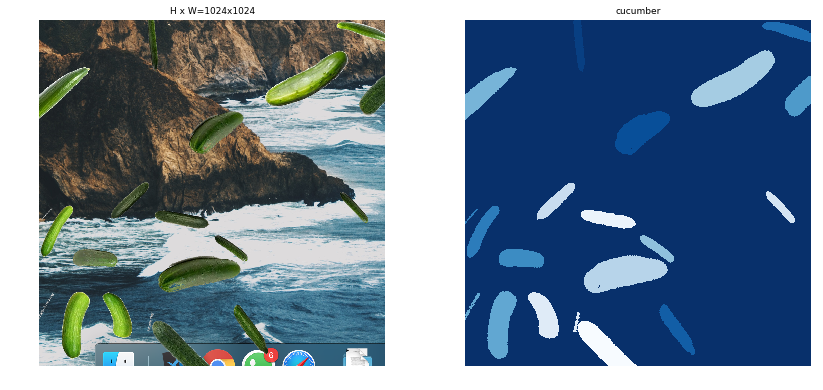

In [4]:


#show n random image&mask train examples
n = 1
image_ids = np.random.choice(dataset_train.image_ids, n)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(image.shape)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, 1)




20


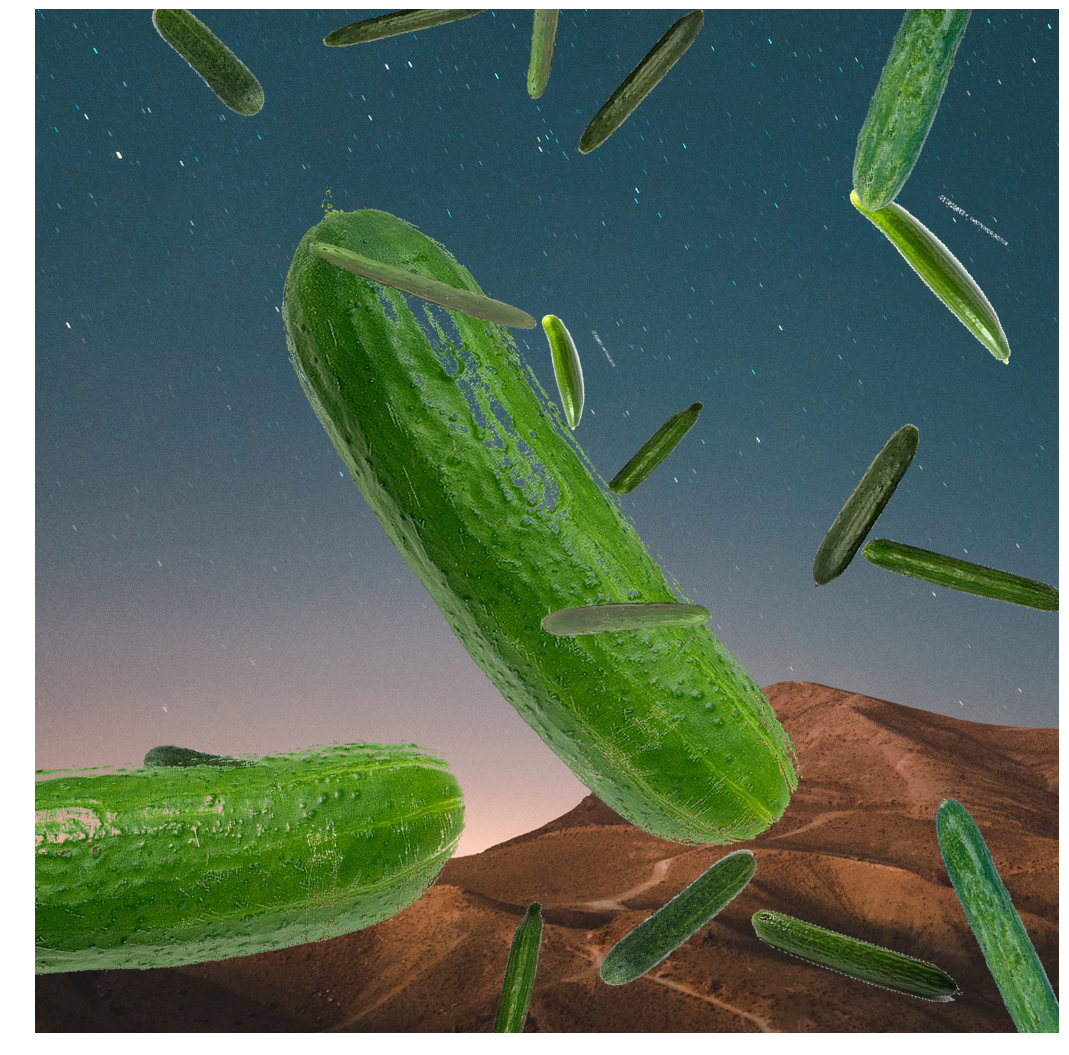

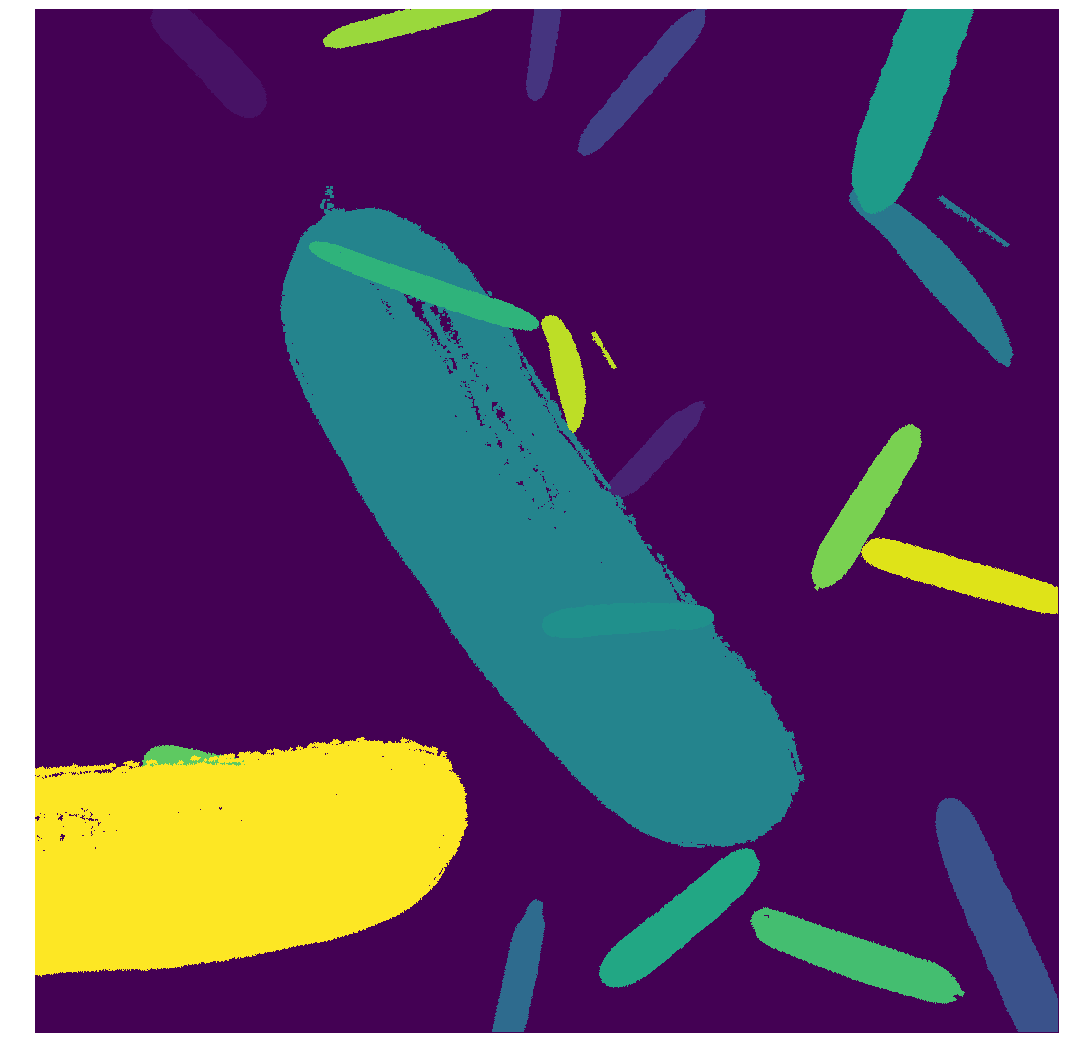

In [5]:


w = 16
h = 16


n = 1
image_ids = np.random.choice(dataset_train.image_ids, n)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    
    fig = plt.figure(frameon=False, dpi=64)
    fig.set_size_inches(w,h)

    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    plt.imshow(image)
    # fig.savefig('/Users/AsherYartsev/Desktop' + str(image_id) + '.png')
    
    
    fig = plt.figure(frameon=False, dpi=64)
    fig.set_size_inches(w,h)

    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    plt.imshow(mask_to_image(mask))
    # fig.savefig('/Users/AsherYartsev/Desktop' + str(image_id) + '.png')

    plt.show()
    



# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)





In [6]:




# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_by_name('/media/master/96DAE970DAE94CD5/Results/Project07 - MaskRCNN/shapes20181015T1115/mask_rcnn_shapes_1517.h5'), by_name=True)





In [7]:




# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
#asher note: each time only one sort of train is possible as for now.
# model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE, epochs=1, layers='heads')





In [8]:



# asher todo: uncomment later when heads training is working
newLearningRate = config.LEARNING_RATE / 5
model.train(dataset_train, dataset_val, learning_rate=newLearningRate, epochs=1, layers="all")





created data_generators
Instructions for updating:
Use the retry module or similar alternatives.

Starting at epoch 0. LR=0.0002

Checkpoint Path: /home/simon/Mask_RCNN/cucu_train/weightsAndGraphs/cucumbers20181212T2254/mask_rcnn_cucumbers_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c    

/home/simon/anaconda3/envs/cucuEnv/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/simon/anaconda3/envs/cucuEnv/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
steps per epoch: 1
steps done: 0
started loading another image (AUG)
started loading another image (AUG)
started loading another image (AUG)
started loading another image (AUG)
started loading another image (AUG)
started loading another image (AUG)
started loading another image (AUG)
started loading another image (AUG)
started loading another image (AUG)
started loading another image (AUG)
started loading another image (AUG)
started loading another image (AUG)
started loading another image (AUG)
started loading another image (AUG)
started loading another image (AUG)
started loading another image (AUG)
started loading another image (AUG)
started loading another image (AUG)
started loading another image (AUG)
started loading another image (AUG)
started loading another image (AUG)
started loading another image (AUG)
started loading another image (AUG)
started loading another image (AUG)
started loading another image (AUG)
started loading another image (AUG)
started loading anoth

ResourceExhaustedError: OOM when allocating tensor with shape[1,64,64,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: res4j_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](res4j_branch2c/BiasAdd, PermConstNCHWToNHWC-LayoutOptimizer)]]

Current usage from device: /job:localhost/replica:0/task:0/device:GPU:0, allocator: GPU_0_bfc
  96.59MiB from add_2/add
  64.04MiB from bn_conv1/FusedBatchNorm
  64.00MiB from conv1/BiasAdd-0-1-TransposeNCHWToNHWC-LayoutOptimizer
  64.00MiB from res2a_branch1/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  64.00MiB from bn2a_branch2c/FusedBatchNorm
  64.00MiB from res2a_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  64.00MiB from res2b_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  64.00MiB from res2c_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  64.00MiB from add_3/add
  64.00MiB from fpn_c2p2/convolution
  49.00MiB from training/SGD/gradients/Square_234_grad/Mul_1
  49.00MiB from training/SGD/mul_1362
  32.00MiB from bn3a_branch1/FusedBatchNorm
  32.00MiB from res3a_branch1/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  32.00MiB from res3a_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  32.00MiB from res3b_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  32.00MiB from add_5/add
  32.00MiB from res3c_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  32.00MiB from add_6/add
  32.00MiB from res3d_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  32.00MiB from add_7/add
  24.00MiB from fpn_c3p3/convolution
  22.25MiB from res4j_branch2c/convolution
  17.54MiB from bn2a_branch2b/FusedBatchNorm
  16.00MiB from max_pooling2d_1/MaxPool
  16.00MiB from bn2a_branch2a/FusedBatchNorm
  16.00MiB from res2a_branch2a/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from res2a_branch2b/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from bn2b_branch2a/FusedBatchNorm
  16.00MiB from res2b_branch2a/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from bn2b_branch2b/FusedBatchNorm
  16.00MiB from res2b_branch2b/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from bn2c_branch2a/FusedBatchNorm
  16.00MiB from res2c_branch2a/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from bn2c_branch2b/FusedBatchNorm
  16.00MiB from res2c_branch2b/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from bn4a_branch1/FusedBatchNorm
  16.00MiB from res4a_branch1/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from res4a_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from res4b_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from add_9/add
  16.00MiB from res4c_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from add_10/add
  16.00MiB from res4d_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from add_11/add
  16.00MiB from res4e_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from add_12/add
  16.00MiB from res4f_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from add_13/add
  16.00MiB from res4g_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from add_14/add
  16.00MiB from res4h_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from add_15/add
  16.00MiB from res4i_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from add_16/add
  16.00MiB from bn4j_branch2c/FusedBatchNorm
  12.14MiB from conv1/convolution-0-TransposeNHWCToNCHW-LayoutOptimizer
  9.00MiB from training/SGD/gradients/Square_204_grad/Mul_1
  9.00MiB from training/SGD/gradients/Square_198_grad/Mul_1
  9.00MiB from training/SGD/gradients/Square_190_grad/Mul_1
  9.00MiB from training/SGD/mul_1230
  9.00MiB from training/SGD/mul_1262
  9.00MiB from training/SGD/mul_1286
  9.00MiB from res3a_branch2a/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  9.00MiB from bn3a_branch2b/FusedBatchNorm
  9.00MiB from bn3c_branch2a/FusedBatchNorm
  8.00MiB from training/SGD/gradients/Square_194_grad/Mul_1
  8.00MiB from training/SGD/mul_1242
  8.00MiB from bn3a_branch2a/FusedBatchNorm
  8.00MiB from res3a_branch2b/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  8.00MiB from bn3b_branch2a/FusedBatchNorm
  8.00MiB from res3b_branch2a/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  8.00MiB from bn3b_branch2b/FusedBatchNorm
  8.00MiB from res3b_branch2b/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  8.00MiB from res3c_branch2a/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  8.00MiB from bn3c_branch2b/FusedBatchNorm
  8.00MiB from res3c_branch2b/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  8.00MiB from bn3d_branch2a/FusedBatchNorm
  8.00MiB from res3d_branch2a/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  8.00MiB from bn3d_branch2b/FusedBatchNorm
  8.00MiB from res3d_branch2b/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  4.50MiB from res4b_branch2a/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  4.50MiB from training/SGD/gradients/Square_224_grad/Mul_1
  4.50MiB from training/SGD/mul_1334
  4.00MiB from training/SGD/gradients/Square_238_grad/Mul_1
  4.00MiB from training/SGD/gradients/Square_202_grad/Mul_1
  4.00MiB from training/SGD/gradients/Square_206_grad/Mul_1
  4.00MiB from training/SGD/gradients/Square_196_grad/Mul_1
  4.00MiB from training/SGD/gradients/Square_200_grad/Mul_1
  4.00MiB from training/SGD/gradients/Square_192_grad/Mul_1
  4.00MiB from training/SGD/mul_1378
  4.00MiB from training/SGD/mul_1238
  4.00MiB from training/SGD/mul_1254
  4.00MiB from training/SGD/mul_1270
  4.00MiB from training/SGD/mul_1278
  4.00MiB from training/SGD/mul_1294
  4.00MiB from bn4a_branch2a/FusedBatchNorm
  4.00MiB from res4a_branch2a/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  4.00MiB from bn4a_branch2b/FusedBatchNorm
  4.00MiB from res4a_branch2b/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  4.00MiB from bn4b_branch2a/FusedBatchNorm
  Remaining 738 nodes with 397.81MiB

	 [[Node: mrcnn_mask_loss/strided_slice_5/_5713 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_8835_mrcnn_mask_loss/strided_slice_5", tensor_type=DT_INT64, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Current usage from device: /job:localhost/replica:0/task:0/device:GPU:0, allocator: GPU_0_bfc
  96.59MiB from add_2/add
  64.04MiB from bn_conv1/FusedBatchNorm
  64.00MiB from conv1/BiasAdd-0-1-TransposeNCHWToNHWC-LayoutOptimizer
  64.00MiB from res2a_branch1/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  64.00MiB from bn2a_branch2c/FusedBatchNorm
  64.00MiB from res2a_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  64.00MiB from res2b_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  64.00MiB from res2c_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  64.00MiB from add_3/add
  64.00MiB from fpn_c2p2/convolution
  49.00MiB from training/SGD/gradients/Square_234_grad/Mul_1
  49.00MiB from training/SGD/mul_1362
  32.00MiB from bn3a_branch1/FusedBatchNorm
  32.00MiB from res3a_branch1/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  32.00MiB from res3a_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  32.00MiB from res3b_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  32.00MiB from add_5/add
  32.00MiB from res3c_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  32.00MiB from add_6/add
  32.00MiB from res3d_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  32.00MiB from add_7/add
  24.00MiB from fpn_c3p3/convolution
  17.54MiB from bn2a_branch2b/FusedBatchNorm
  16.00MiB from max_pooling2d_1/MaxPool
  16.00MiB from bn2a_branch2a/FusedBatchNorm
  16.00MiB from res2a_branch2a/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from res2a_branch2b/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from bn2b_branch2a/FusedBatchNorm
  16.00MiB from res2b_branch2a/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from bn2b_branch2b/FusedBatchNorm
  16.00MiB from res2b_branch2b/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from bn2c_branch2a/FusedBatchNorm
  16.00MiB from res2c_branch2a/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from bn2c_branch2b/FusedBatchNorm
  16.00MiB from res2c_branch2b/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from bn4a_branch1/FusedBatchNorm
  16.00MiB from res4a_branch1/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from res4a_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from res4b_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from add_9/add
  16.00MiB from res4c_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from add_10/add
  16.00MiB from res4d_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from add_11/add
  16.00MiB from res4e_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from add_12/add
  16.00MiB from res4f_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from add_13/add
  16.00MiB from res4g_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from add_14/add
  16.00MiB from res4h_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from add_15/add
  16.00MiB from res4i_branch2c/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  16.00MiB from add_16/add
  16.00MiB from bn4j_branch2c/FusedBatchNorm
  12.14MiB from conv1/convolution-0-TransposeNHWCToNCHW-LayoutOptimizer
  9.00MiB from training/SGD/gradients/Square_204_grad/Mul_1
  9.00MiB from training/SGD/gradients/Square_198_grad/Mul_1
  9.00MiB from training/SGD/gradients/Square_190_grad/Mul_1
  9.00MiB from training/SGD/mul_1230
  9.00MiB from training/SGD/mul_1262
  9.00MiB from training/SGD/mul_1286
  9.00MiB from res3a_branch2a/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  9.00MiB from bn3a_branch2b/FusedBatchNorm
  9.00MiB from bn3c_branch2a/FusedBatchNorm
  8.00MiB from training/SGD/gradients/Square_194_grad/Mul_1
  8.00MiB from training/SGD/mul_1242
  8.00MiB from bn3a_branch2a/FusedBatchNorm
  8.00MiB from res3a_branch2b/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  8.00MiB from bn3b_branch2a/FusedBatchNorm
  8.00MiB from res3b_branch2a/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  8.00MiB from bn3b_branch2b/FusedBatchNorm
  8.00MiB from res3b_branch2b/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  8.00MiB from res3c_branch2a/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  8.00MiB from bn3c_branch2b/FusedBatchNorm
  8.00MiB from res3c_branch2b/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  8.00MiB from bn3d_branch2a/FusedBatchNorm
  8.00MiB from res3d_branch2a/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  8.00MiB from bn3d_branch2b/FusedBatchNorm
  8.00MiB from res3d_branch2b/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  4.50MiB from res4b_branch2a/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  4.50MiB from training/SGD/gradients/Square_224_grad/Mul_1
  4.50MiB from training/SGD/mul_1334
  4.00MiB from training/SGD/gradients/Square_238_grad/Mul_1
  4.00MiB from training/SGD/gradients/Square_202_grad/Mul_1
  4.00MiB from training/SGD/gradients/Square_206_grad/Mul_1
  4.00MiB from training/SGD/gradients/Square_196_grad/Mul_1
  4.00MiB from training/SGD/gradients/Square_200_grad/Mul_1
  4.00MiB from training/SGD/gradients/Square_192_grad/Mul_1
  4.00MiB from training/SGD/mul_1378
  4.00MiB from training/SGD/mul_1238
  4.00MiB from training/SGD/mul_1254
  4.00MiB from training/SGD/mul_1270
  4.00MiB from training/SGD/mul_1278
  4.00MiB from training/SGD/mul_1294
  4.00MiB from bn4a_branch2a/FusedBatchNorm
  4.00MiB from res4a_branch2a/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  4.00MiB from bn4a_branch2b/FusedBatchNorm
  4.00MiB from res4a_branch2b/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer
  4.00MiB from bn4b_branch2a/FusedBatchNorm
  4.00MiB from bn4b_branch2b/FusedBatchNorm
  Remaining 737 nodes with 393.81MiB


In [12]:


# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "cucuWheights.h5")
model.keras_model.save_weights(model_path)




In [14]:


class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(MODEL_DIR, "cucuWheights.h5")
# model_path = model.find_last()


# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)




Loading weights from  /home/simon/Mask_RCNN/cucu_train/weightsAndGraphs/cucuWheights.h5


0
original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  int64
gt_class_id              shape: (42,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (42, 4)               min:    0.00000  max: 1023.00000  int32
gt_mask                  shape: (1024, 1024, 42)      min:    0.00000  max:    1.00000  bool


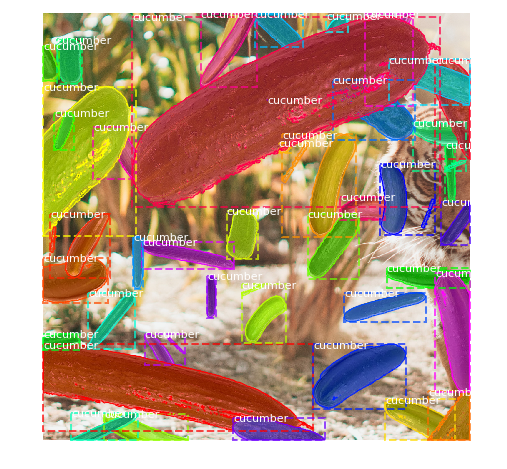

In [15]:


# Test on a random image
image_id = random.choice(dataset_val.image_ids)
print(image_id)
#image_id = 1
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, dataset_train.class_names, figsize=(8, 8))




Processing 1 images
image                    shape: (183, 275, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32
['BG', 'cucumber']


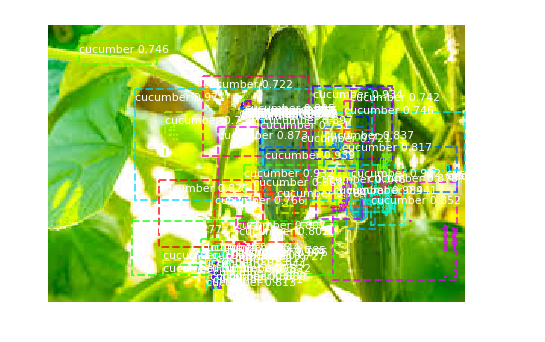

In [17]:


# In[7]:


def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax



t = cv2.cvtColor(cv2.imread(ROOT_DIR+'/cucu_train/simple_test/test1.jpeg'), cv2.COLOR_BGR2RGB)
#original_image.shape
results = model.detect([t], verbose=1)

r = results[0]
visualize.display_instances(t, r['rois'], r['masks'], r['class_ids'], dataset_train.class_names, r['scores'], ax=get_ax())
# visualize.save_instances(t, r['rois'], r['masks'], r['class_ids'], dataset_train.class_names, r['scores'], ax=get_ax(), save_to='/Users/AsherYartsev/Desktop/temp/result_0150_bananas.png')
t= dataset_train.class_names
print(t)

#asher todo: get inspiration from this later
# # In[28]:


# #from os import walk
# #from os import listdir


# class InferenceConfig(ShapesConfig):
#     GPU_COUNT = 1
#     IMAGES_PER_GPU = 1

# inference_config = InferenceConfig()


# model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)
# # Recreate the model in inference mode
# mypath = '/home/simon/Mask_RCNN/cucu_train/weightsAndGraphs'
# mypath_out = '/home/simon/Mask_RCNN/cucu_train/simple_test_OUT'

# # Get path to saved weights
# # Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# #model_path = model.find_last()


# t = cv2.cvtColor(cv2.imread('/home/master/Work/Tensorflow/Project07 - MaskRCNN/data/results/N09/avocado/2018-06-21_AV_leaves_01_1024_02.jpg'), cv2.COLOR_BGR2RGB)
# #original_image.shape



# #f = []
# #for (dirpath, dirnames, filenames) in walk(mypath):
# #    print(os.path.join(mypath,filenames))
#     #f.extend(filenames)
#     #break
    
# for filename in sorted(os.listdir(mypath)):
    
#     full_name = os.path.join(mypath,filename)
#     # model_path = model.find_by_name(full_name)
#     # Load trained weights
#     print("Loading weights from ", full_name)
#     model.load_weights(model_path=full_name, by_name=True)
    
#     results = model.detect([t], verbose=1)

#     r = results[0]
#     base = os.path.splitext(filename)[0]
#     image_name = base + ".png"
    
#     visualize.save_instances(t, r['rois'], r['masks'], r['class_ids'], dataset_train.class_names, r['scores'], ax=get_ax(), save_to=os.path.join(mypath_out, image_name))


# # In[ ]:


# results = model.detect([original_image], verbose=1)

# r = results[0]
# visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], dataset_val.class_names, r['scores'], ax=get_ax())




In [ ]:


# # Compute VOC-Style mAP @ IoU=0.5
# # Running on 10 images. Increase for better accuracy.
# image_ids = np.random.choice(dataset_val.image_ids, 100)
# APs = []
# for image_id in image_ids:
#     # Load image and ground truth data
#     image, image_meta, gt_class_id, gt_bbox, gt_mask =        modellib.load_image_gt(dataset_val, inference_config,
#                                image_id, use_mini_mask=False)
#     molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
#     # Run object detection
#     results = model.detect([image], verbose=0)
#     r = results[0]
#     # Compute AP
#     AP, precisions, recalls, overlaps =        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
#                          r["rois"], r["class_ids"], r["scores"], r['masks'])
#     APs.append(AP)
    
# print("mAP: ", np.mean(APs))


